In [1]:
%pylab inline
import theano
import theano.tensor as TT
import lasagne
import lasagne.layers as LL
import lasagne.nonlinearities as LN
import lasagne.init as LI
from common.plotting import plot_mat


from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme
CIFAR10.default_transformers = ((ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
                                (Cast, [np.float32], {'which_sources': 'features'}))
cifar10_train = CIFAR10(("train",), subset=slice(None,40000))
# this stream will shuffle the CIFAR10 set and return us batches of 100 examples
cifar10_train_stream = DataStream.default_stream(cifar10_train,
                                                 iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 25))
cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))
# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(cifar10_validation,
                                                      iteration_scheme=SequentialScheme(cifar10_validation.num_examples,
                                                                                        100))
cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(cifar10_test,
                                                iteration_scheme=SequentialScheme(cifar10_test.num_examples, 100))


# Check print
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)
print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days
Using gpu device 0: GeForce GTX 780 (CNMeM is enabled)
/home/i265983/Dokumenty/nn_assignments/libs/Theano/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Populating the interactive namespace from numpy and matplotlib
The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [2]:
class ConvNeuralNet:
    wdec_layers = [LL.Conv2DLayer, LL.DenseLayer]
    def __init__(self, input_var, target_var, layers, data_shape, batch_size=None):
        self.input_var = input_var
        self.target_var = target_var
        self.layers = [LL.InputLayer(shape=(batch_size,)+data_shape,
                                     input_var=self.input_var)]
        #self.wdec = 0
        for layer in layers:
            if layer['type'] == LL.DenseLayer and 'W' not in layer['args']:
                shape = LL.get_output_shape(self.layers[-1])
                layer['args']['W'] = LI.Uniform(range=(1. / np.sqrt(shape[1])))
            self.layers.append(layer['type'](incoming=self.layers[-1], **layer['args']))
            #if layer['type'] in ConvNeuralNet.wdec_layers:
            #    self.wdec += lasagne.regularization.l2(self.layers[-1].W)
        self.network = self.layers[-1]
        #self.wdec = TT.sum([lasagne.regularization.l2(param)
        #                    for param in LL.get_all_params(self.network, regularizable=True)])
        self.wdec = lasagne.regularization.regularize_network_params(self.network,
                                                                     lasagne.regularization.l2)
        
    def initialize(self, learning_rate, momentum, wdec_const):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.wdec_const = wdec_const
        
        self.prediction = LL.get_output(self.network, deterministic=False)
        self.loss = lasagne.objectives.categorical_crossentropy(self.prediction, self.target_var)
        self.loss = self.loss.mean() + self.wdec_const * self.wdec
        
        self.params = LL.get_all_params(self.network, trainable=True)
        # https://blogs.princeton.edu/imabandit/2013/04/01/acceleratedgradientdescent/
        self.updates = lasagne.updates.nesterov_momentum(self.loss,
                                                self.params,
                                                learning_rate=self.learning_rate,
                                                momentum=self.momentum)
        
        self.train_acc = TT.mean(TT.eq(TT.argmax(self.prediction, axis=1), self.target_var),
                                 dtype=theano.config.floatX)
        
        self.test_prediction = LL.get_output(self.network, deterministic=True)
        self.test_loss = lasagne.objectives.categorical_crossentropy(self.test_prediction,
                                                                     self.target_var)
        self.test_loss = self.test_loss.mean()
        self.test_acc = TT.mean(TT.eq(TT.argmax(self.test_prediction, axis=1), self.target_var),
                                dtype=theano.config.floatX)
        
        self.train_fn = theano.function([self.input_var, self.target_var],
                                        [self.loss, self.train_acc],
                                        updates=self.updates)
        self.val_fn = theano.function([self.input_var, self.target_var],
                                      [self.test_loss, self.test_acc])
        self.test_prediction_fn = theano.function([self.input_var], [self.test_prediction])


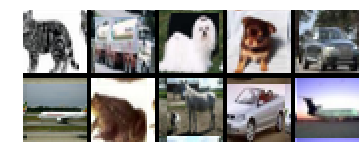

In [3]:
class Transform(object):
    def __init__(self, rng=None):
        if rng == None:
            rng = numpy.random
        self.rng = rng
    
    def transform(self, X):
        return X
    
    def name(self):
        return "Identity transformation"

class Shift(Transform):
    def __init__(self, shift_size=4, **kwargs):
        super(Shift, self).__init__(**kwargs)
        self.shift_size = shift_size
        
    def transform(self, X):
        res = X
        for i in xrange(res.shape[0]):
            res[i] = np.roll(res[i], self.rng.randint(-self.shift_size, self.shift_size + 1), axis=1)
            res[i] = np.roll(res[i], self.rng.randint(-self.shift_size, self.shift_size + 1), axis=2)
        return res
    
    def name(self):
        return "Random shift by %d" % self.shift.size
    
trans = [trans() for trans in Transform.__subclasses__()]
def random_transform(X_batch):
    global trans
    return trans[np.random.randint(0, len(trans))].transform(X_batch)

# example of transformation
for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator():
    X = X_batch
    break
X = random_transform(X[:10])
plot_mat(X, cmap='gray')

In [4]:
input_var = TT.tensor4('inputs')
target_var = TT.ivector('targets')

net = ConvNeuralNet(input_var, target_var,
                    layers=[{'type' : LL.Conv2DLayer,
                             'args' : {'num_filters' : 50,
                                       'filter_size' : (5,5),
                                       'nonlinearity' : LN.rectify,
                                       'W' : LI.Normal(std=0.05,mean=0.0)}},
                            {'type' : LL.MaxPool2DLayer,
                             'args' : {'pool_size' : (2,2)}},
                            {'type' : LL.DropoutLayer,
                             'args' : {'p' : 0.2}},
                            {'type' : LL.Conv2DLayer,
                             'args' : {'num_filters' : 100,
                                       'filter_size' : (5,5),
                                       'nonlinearity' : LN.rectify,
                                       'W' : LI.Normal(std=0.05,mean=0.0)}},
                            {'type' : LL.MaxPool2DLayer,
                             'args' : {'pool_size' : (2,2)}},
                            {'type' : LL.DropoutLayer,
                             'args' : {'p' : 0.2}},
                            {'type' : LL.FlattenLayer,
                             'args' : {}},
                            {'type' : LL.DenseLayer,
                             'args' : {'num_units' : 500,
                                       'nonlinearity' : LN.rectify}},
                            {'type' : LL.DropoutLayer,
                             'args' : {'p' : 0.5}},
                            {'type' : LL.DenseLayer,
                             'args' : {'num_units' : 500,
                                       'nonlinearity' : LN.rectify}},
                            {'type' : LL.DropoutLayer,
                             'args' : {'p' : 0.5}},
                            {'type' : LL.DenseLayer,
                             'args' : {'num_units' : 100,
                                       'nonlinearity' : LN.rectify}},
                            {'type' : LL.DropoutLayer,
                             'args' : {'p' : 0.5}},
                            {'type' : LL.DenseLayer,
                             'args' : {'num_units' : 10,
                                       'nonlinearity' : LN.softmax}}
                    ],
                    data_shape = (3,32,32))

l_rate = theano.shared(np.array(0.01, dtype=theano.config.floatX))
momentum = 0.9
wdec_const = 1e-3 #3e-3
net.initialize(l_rate, momentum, wdec_const)

/home/i265983/.local/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [5]:
def snapshot_params(net):
    return LL.get_all_param_values(net.network)
def load_params(net, params):
    LL.set_all_param_values(net.network, params)
    
def compute_error_rate(stream, net):
    accs = 0.0
    loss = 0.0
    num_batches = 0.0
    for X, Y in stream.get_epoch_iterator():
        batch_loss, batch_acc = net.val_fn(X,Y.ravel())
        loss += batch_loss
        accs += batch_acc
        num_batches += 1
    return loss/num_batches, 1 - accs/num_batches

Learning started at 14:04:14
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch 1 took 31.988s, currently going to do 5
  training loss: 2.467094, validation loss: 1.622855
  validation accuracy:		39.01%
  training accuracy:		25.30%
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch 2 took 30.911s, currently going to do 5
  training loss: 2.017827, validation loss: 1.345108
  validation accuracy:		50.58%
  training accuracy:		39.30%
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch 3 took 30.911s, currently going to do 7
  training loss: 1.837685, validation loss: 1.320329
  validation accuracy:		53.48%
  training accuracy:		45.78%
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch 4 took 31.768s, currently going to do 9
  training loss: 1.743103, validation loss: 1.184068
  validation accuracy:		58.86%
  training accuracy:		50.58%
. . . . . .

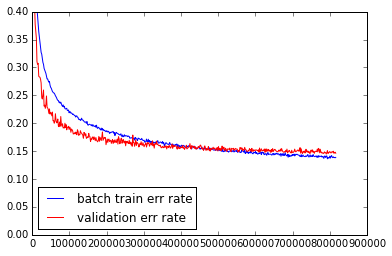

In [6]:
import time
import pickle
from datetime import datetime

i=0
e=0

best_valid_error_rate = np.inf
best_params_epoch = 0
best_params = snapshot_params(net)

train_erros = []
train_losses = []
validation_errors = []

number_of_epochs = 5
patience_expansion = 2.

base_lrate = 1e-2
K = 10000

# training loop

try:
    print "Learning started at %02d:%02d:%02d" % (datetime.now().hour, datetime.now().minute, datetime.now().second)
    while e < number_of_epochs: #This loop goes over epochs
        e += 1

        epoch_start_i = i
        train_loss = 0.0
        train_acc = 0.0
        start_time = time.time()
        for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator(): 
            i += 1
            X_batch = random_transform(X_batch)
            net.learning_rate.set_value(base_lrate * K / np.maximum(K, i))
            batch_loss, batch_acc = net.train_fn(X_batch, Y_batch.ravel())
            train_loss += batch_loss
            train_acc += batch_acc
            if i % 40 == 0:
                print '.',
            
        val_loss, val_error_rate = compute_error_rate(cifar10_validation_stream, net)
        if val_error_rate < best_valid_error_rate:
            number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
            best_valid_error_rate = val_error_rate
            best_params = snapshot_params(net)
            best_params_epoch = e
            pickle.dump(best_params, open('LasagneTest.pkl', 'w'))
            pickle.dump(e, open('LasagneTest_e.pkl', 'w'))
            pickle.dump(i, open('LasagneTest_i.pkl', 'w'))
            pickle.dump(number_of_epochs, open('LasagneTest_number_of_epochs.pkl', 'w'))

        train_batches = i - epoch_start_i
        validation_errors.append((i,val_error_rate))
        train_losses.append((i,train_loss / train_batches))
        train_erros.append((i,1-train_acc / train_batches))
        print "\nEpoch %d took %.3fs, currently going to do %d" % (e, time.time() - start_time,
                                                                   number_of_epochs)
        print "  training loss: %.6f, validation loss: %.6f" % (train_loss / train_batches, val_loss)
        print "  validation accuracy:\t\t%.2f%%" % (100 - val_error_rate * 100)
        print "  training accuracy:\t\t%.2f%%" % (train_acc / train_batches * 100)
except KeyboardInterrupt:
    print "\nKeyboard interruption, user stopped learning"

print "Learning ended at %02d:%02d:%02d" % (datetime.now().hour,
                                            datetime.now().minute,
                                            datetime.now().second)
    
print "Setting network parameters from after epoch %d" % (best_params_epoch)
load_params(net, best_params)

_, test_err_rate = compute_error_rate(cifar10_test_stream, net)
print "Test error rate: %f%%" % (test_err_rate)

# subplot(2,1,1)
# train_losses = np.array(train_losses)
# semilogy(train_losses[:,0], train_losses[:,1], label='batch train loss')
# legend()

# subplot(2,1,2)
train_erros = np.array(train_erros)
plot(train_erros[:,0], train_erros[:,1], label='batch train err rate')
validation_errors = np.array(validation_errors)
plot(validation_errors[:,0], validation_errors[:,1], label='validation err rate', color='r')
ylim(0,0.4)
legend(loc='lower left')